# Modeling

First thing, I want to see what the simplest, baseline model for my data is. To do this, I will just find whatever I have that correlates the most with PRICE and then create a model with it.

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import functions

In [39]:
# Import data
kc = pd.read_csv('../../Data/matthew_clean_data.csv', index_col=0)

In [40]:
# Create Correlation matrix
kc_matrix = kc.corr()
kc_matrix['price']

id             -0.016772
price           1.000000
grade           0.667951
yr_built        0.053953
yr_renovated    0.125499
floors_1.5      0.015896
floors_2.0      0.232696
floors_2.5      0.122845
floors_3.0      0.020036
floors_3.5      0.018132
Name: price, dtype: float64

## Simple Model: Price ~ Grade

In [44]:
# Grade seems to have the highest correlation here. Let's start there

#Train/Test Split
X = kc.drop(columns=['price', 'date', 'yr_renovated'])
y = kc['price']

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)

model = sm.OLS(y_train, sm.add_constant(X_train['grade'])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                 1.145e+04
Date:                Tue, 05 Oct 2021   Prob (F-statistic):               0.00
Time:                        20:49:59   Log-Likelihood:            -2.0167e+05
No. Observations:               14469   AIC:                         4.033e+05
Df Residuals:                   14467   BIC:                         4.033e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.298e+05   9326.306    -46.081      0.000   -4.48e+05   -4.11e+05
grade        2.08e+05   1943.134    107.022      0.000    2.04e+05    2.12e+05
==============================================================================
Omnibus:                    14201.887   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1991063.624
Skew:                           4.436   Prob(JB):                         0.00
Kurtosis:                      59.779   Cond. No.                         20.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
# For comparing the models, let's also use our evaluate() function to get R2, RMSE, MAE
train_preds = model.predict(sm.add_constant(X_train['grade']))
test_preds = model.predict(sm.add_constant(X_test['grade']))
functions.evaluate(y_train, train_preds, y_test, test_preds)

Train R2: 0.4451
Test R2: 0.4483
****
Train RMSE: $273,906.01
Test RMSE: $272,348.61
****
Train MAE: $175,198.94
Test MAE: $175,894.44


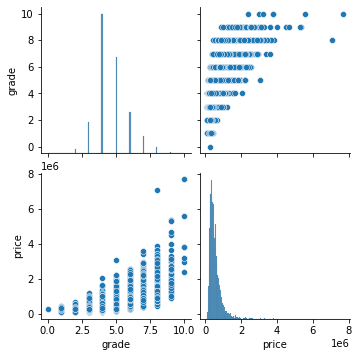

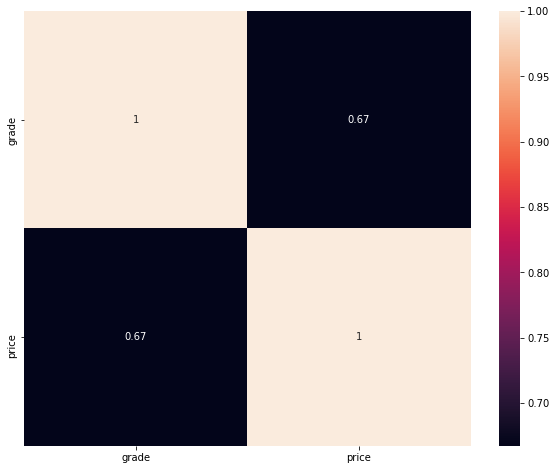

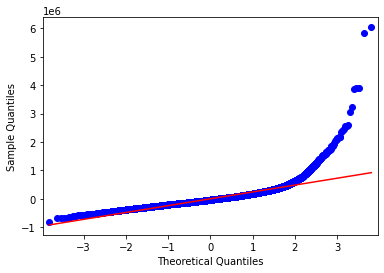

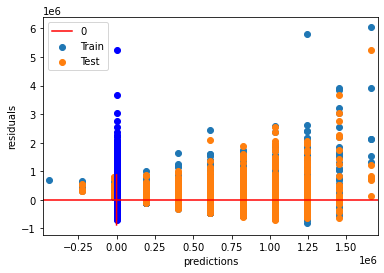

In [43]:
# Let's also check the assumptions of linearity.
functions.check_assumptions(X_train['grade'], y_train, train_preds, test_preds, y_test)

## Conclusion
Looking at the results two things stick out to me:
- The RMSE and MAE have a difference of about $98,000 dollars.

- This model violates the "residual normality" assumption of linear regression. The Jarque-Bera score of 1,991,063 also reinforces this.
- It may also have some heteroscedasticity as well, violating another assumption.

This is definitely a good start, but I think it would benefit any model moving forward to remove the extreme outliers.

## (Price ~ Grade) with removed outliers

In [103]:
# Remove the 5% most expensive houses
kc_trim = kc[kc['price'] < kc['price'].quantile(0.95)]
kc_trim.describe()

# Redo the Train/Test Split and exclude outliers
X = kc_trim.drop(columns=['price', 'date', 'yr_renovated'])
y = kc_trim['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)

model = sm.OLS(y_train, sm.add_constant(X_train['grade'])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     9315.
Date:                Tue, 05 Oct 2021   Prob (F-statistic):               0.00
Time:                        22:09:31   Log-Likelihood:            -1.8438e+05
No. Observations:               13743   AIC:                         3.688e+05
Df Residuals:                   13741   BIC:                         3.688e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.023e+05   6185.069    -16.545      0.000   -1.14e+05   -9.02e+04
grade       1.281e+05   1327.667     96.514      0.000    1.26e+05    1.31e+05
==============================================================================
Omnibus:                      990.377   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1242.723
Skew:                           0.676   Prob(JB):                    1.40e-270
Kurtosis:                       3.586   Cond. No.                         21.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [98]:
train_preds = model.predict(sm.add_constant(X_train['grade']))
test_preds = model.predict(sm.add_constant(X_test['grade']))
functions.evaluate(y_train, train_preds, y_test, test_preds)

Train R2: 0.4020
Test R2: 0.4092
****
Train RMSE: $162,977.02
Test RMSE: $163,061.07
****
Train MAE: $128,502.83
Test MAE: $129,047.17


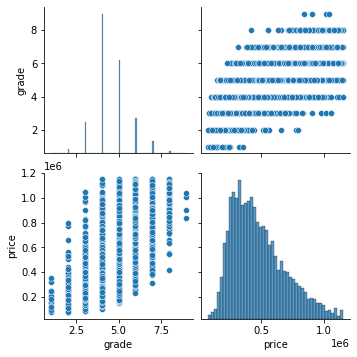

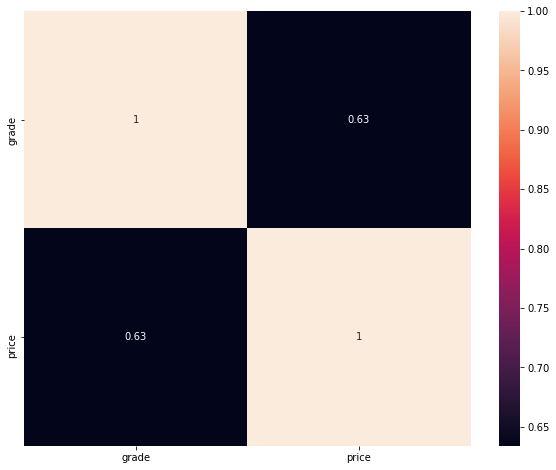

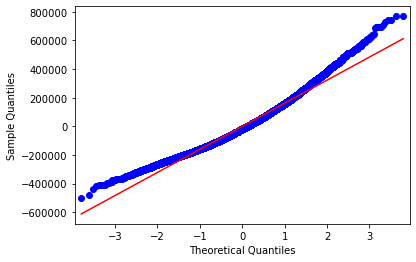

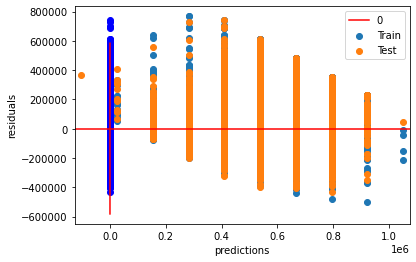

In [99]:
functions.check_assumptions(X_train['grade'], y_train, train_preds, test_preds, y_test)

## Conclusion
This test is interesting:
- The R-Squared went down by about 0.082

but:
- our RMSE went down by about $111,000
- our MSE went down by abour $47,000
- The model still violates the “residual normality” assumption of linear regression. However The Jarque-Bera is now 1270, *much* lower then the previous score of 1,991,063!
- The heteroscedasticity still seems to be present

Overall, I'd say this is an improvement! I think it would be smart to remove outliers like I've done here for any models moving forward. I think it would also be possible to tune the quantile I use to further improve accuracy. For now, I think it'd be better to move on.